# Traffic Signs Classification
Here i'm gonna be trying to classify traffic signs from crops that are going to be coming for a YOLO detector, since YOLO doesn't have much accuracy, but it detects traffic signs, I'm going to take the bounding box from YOLO, crop the image, and pass it through this classifier.

Let's see if it actually works **;)**

If you want to skip the set-up go to the [Model](#Model) section.

In [1]:
import os
import cv2
import json
import glob
import pickle
import random
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)

Using TensorFlow backend.


In [2]:
# Data folder
data_folder = 'data/20-classes/'

# Pickle files
train_pickle_file = 'train.p' 
valid_pickle_file = 'valid.p'

# Classes file
classes_file = 'classes.json'

In [3]:
# Load classes
with open(os.path.join(data_folder, classes_file), mode='r') as json_file:
    classes = json.load(json_file)

In [6]:
# Load train data
train_file = open(os.path.join(data_folder, train_pickle_file), 'rb')
train_data = pickle.load(train_file)

# Load valid data
valid_file = open(os.path.join(data_folder, valid_pickle_file), 'rb')
valid_data = pickle.load(valid_file)

In [7]:
# Data shapes
print('Train data shape:', train_data['features'].shape)
print('Valid data shape:', valid_data['features'].shape)

Train data shape: (29676, 64, 64, 3)
Valid data shape: (12732, 64, 64, 3)


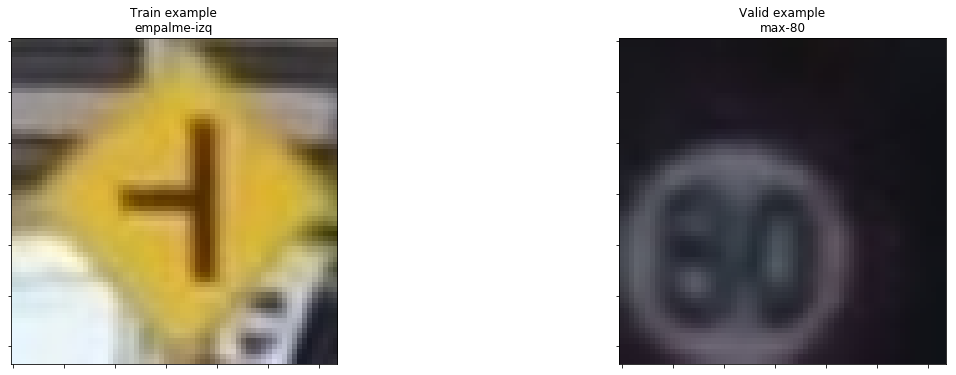

In [8]:
# Verify data
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

index = random.randrange(0, len(train_data['features']))
ax1.imshow(train_data['features'][index])
ax1.set_title('Train example\n' + classes[str(train_data['labels'][index])]['name'])
ax1.set_yticklabels([])
ax1.set_xticklabels([])

index = random.randrange(0, len(valid_data['features']))
ax2.imshow(valid_data['features'][index])
ax2.set_title('Valid example\n' + classes[str(valid_data['labels'][index])]['name'])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

plt.show()

### Data convertion

In [9]:
NUM_CLASSES = len(classes.keys())
IMG_SIZE = 64

In [10]:
# Organize data
x_train = train_data['features']
y_train = train_data['labels']

x_valid = valid_data['features']
y_valid = valid_data['labels']

In [11]:
# Convert labels to one hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)

# Model

In [12]:
# Checkpoint path
checkpoint_path = 'checkpoints/'

# Model name
model_name = 'model-1-20-classes-vgg-19'

In [13]:
datagen = ImageDataGenerator(rotation_range=5,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1./255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               fill_mode='nearest')

In [14]:
datagen.fit(x_train)

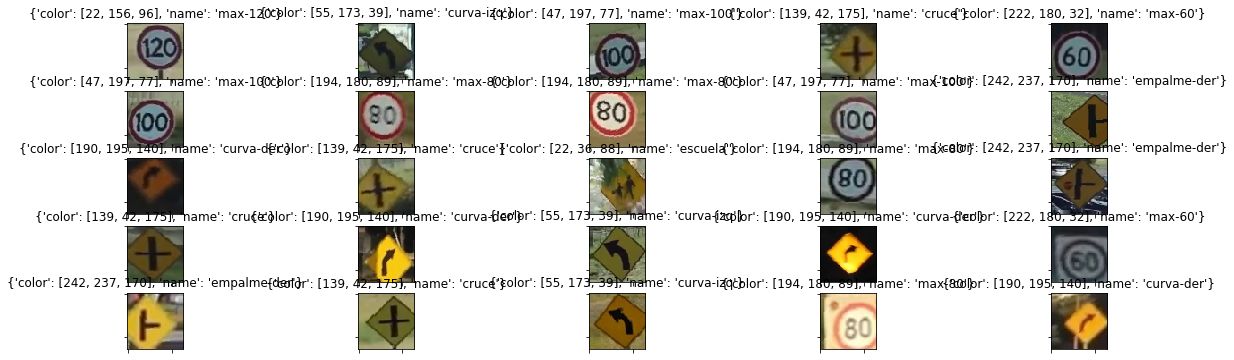

In [15]:
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
    for i in range(0, 25):
        plt.subplot(5, 5, 0 + 1 + i)
        plt.imshow(x_batch[i], cmap=plt.get_cmap('gray'))
        plt.gca().set_yticklabels([])
        plt.gca().set_xticklabels([])
        class_id = np.argmax(y_batch[i])
        plt.title(classes[str(class_id)])
    plt.show()
    break

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

def model(weights_path=None):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    if weights_path:
        model.load_weights(weights_path)
    
    return model

In [18]:
train_model = model()

In [19]:
train_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       295168    
__________

In [20]:
from keras.optimizers import SGD

# Optimizer
lr = 1e-3
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model
train_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [21]:
# Callbacks
filepath = model_name + '-weights-{epoch:02d}-{val_acc:.2f}.hdf5'
folder = os.path.join(checkpoint_path, model_name)
filepath = os.path.join(folder, filepath)

callbacks = [
                keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='val_acc', 
                                                verbose=0, 
                                                save_best_only=False, 
                                                save_weights_only=False, 
                                                mode='auto', 
                                                period=1),
                keras.callbacks.TensorBoard(log_dir='./logs/model-1-20-classes-vgg19/', 
                                            histogram_freq=0, 
                                            write_graph=True, 
                                            write_images=False, 
                                            embeddings_freq=0, 
                                            embeddings_layer_names=None, 
                                            embeddings_metadata=None)
            ]

In [22]:
# Define model parameters
BATCH_SIZE = 256
EPOCHS = 64

In [ ]:
# Fit model
train_model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

Train on 29676 samples, validate on 12732 samples
Epoch 1/64
 6400/29676 [=====>........................] - ETA: 53s - loss: 3.4967 - acc: 0.1428

### Obtain best model weights

In [29]:
# Evaluate model
file_filter = '*.hdf5'
folder = os.path.join(checkpoint_path, model_name)
weights_files = sorted(glob.glob(os.path.join(folder, file_filter)))

data = {}

for weight_file in tqdm_notebook(weights_files):
    # Load weights
    test_model = model(weights_path=weight_file)

    # Compile model
    test_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    # Evaluate model
    score = test_model.evaluate(x_test, y_test, verbose=0)

    data[weight_file] = {'test_loss': score[0], 'test_acc': score[1]}

NameError: name 'x_test' is not defined

In [43]:
max_acc = 0
max_acc_weights = None

for key in data.keys():
    if data[key]['test_acc'] > max_acc:
        max_acc = data[key]['test_acc']
        max_acc_weights = key
        
print(max_acc)
print(max_acc_weights)

0.980519480519
checkpoints/model-1/model-1-weights-41-1.00.hdf5


### Simple test on images

In [29]:
test_path = '/home/arian/Test'

files = glob.glob(os.path.join(test_path,'*.jpg'))
files.extend(glob.glob(os.path.join(test_path, '*.png')))

2.46647e-06
5.93568e-05
8.24777e-07
2.2365e-05
9.36065e-07
1.88926e-05
0.0404115
0.00993201
2.47458e-06


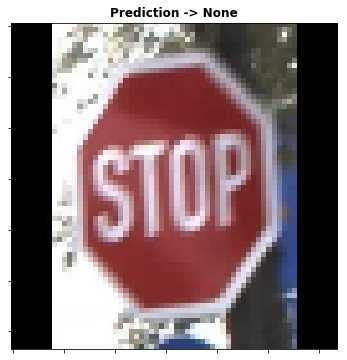

In [60]:
# Test on external image
image_path = files[1]
img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img[...,::-1]

# Predict label for external test image
img_test = np.expand_dims(img, axis=0)
predictions = test_model.predict(img_test)[0]

for prediction in predictions:
    print(prediction)

class_id = np.argmax(predictions)

threshold = 0.1

if predictions[class_id] > threshold:
    class_label = classes[str(class_id)]
else:
    class_label = 'None'

# Plot image with class label
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(img)
ax.set_title('Prediction -> ' + class_label, fontweight="bold")
plt.show()